In [1]:
import sys
sys.path.append('./')
import numpy as np
import os
import datetime
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv2D, Dense, DepthwiseConv2D,add
from keras.optimizers import SGD, Adam
import numpy as np
import math
import keras
from PIL import Image
from random import shuffle
from keras import layers as KL
from Anchors import get_anchors
from Datasets import SSDDatasets
from learning_rate import WarmUpCosineDecayScheduler
from loss import MultiboxLoss
from Models import SSD300
from utils import get_classes, show_config
from log_record import record_log, read_log
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard)
from callbacks import (ExponentDecayScheduler, LossHistory,
                       ParallelModelCheckpoint, EvalCallback)


2023-08-10 05:20:09.604922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 05:20:09.706197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-10 05:20:09.706219: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-10 05:20:10.188770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
from keras.regularizers import l2

if __name__ == "__main__":
    
    # 设置训练参数
    Epoch = 500  # 训练100 epochs
    lr = 1e-3  # Adam优化器，所以较小的学习率
    optimizer_type = "Adam"
    momentum = 0.937
    batch_size = 32
    imgcolor = 'grey'  # imgcolor选“rgb” or “grey”, 则处理图像变单通道或者三通道
    tmp_dir = str(datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d'))
    save_dir = "/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/"+tmp_dir
    
    # 设置SSD参数
    cls_name_path = "./model_data/voc_classes.txt"  # 导入目标检测类别；
    input_shape = [120, 160]  # 输入的尺寸大小
    anchor_size = [32, 59, 86, 113, 141, 168]  # 用于设定先验框的大小，根据公式计算而来；如果要检测小物体，修改浅层先验框的大小，越小的话，识别的物体越小；    
    train_annotation_path = '2007_train.txt'  # 训练图片路径和标签
    val_annotation_path = '2007_val.txt'  # 验证图片路径和标签
    
    # 1. 获取classes和anchor
    class_names, num_cls = get_classes(cls_name_path)
    num_cls += 1  # 增加一个背景类别
    print("class_names:", class_names, "num_classes:", num_cls)
    
    # 2. 获取anchors, 输出的是归一化之后的anchors
    anchor = get_anchors(input_shape, anchor_size)
    print("type:",type(anchor), "shape:", np.shape(anchor))

    # 3. 模型编译
    K.clear_session()
    model_path = ""
    # model_path = "./output/20230804_3/good_detection_test_callback.h5"
    model = SSD300((input_shape[0], input_shape[1], 1), num_cls)
    # model.save("template.h5")
    # model.summary()
    if model_path != "":
        model.load_weights(model_path, by_name = True, skip_mismatch=True)
       
    # 4. 优化器
    # optimizer = Adam(lr = lr, beta_1=momentum)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # 5. 导入数据集
    with open(train_annotation_path, encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(val_annotation_path, encoding='utf-8') as f:
        val_lines = f.readlines()
    num_train = len(train_lines)
    num_val = len(val_lines)
    epoch_step = num_train // batch_size
    epoch_step_val = num_val // batch_size
    train_dataloader = SSDDatasets(train_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    val_dataloader = SSDDatasets(val_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
    # 6. 编译模型
    # losses = {'mbox_loc_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,
            #   'cls_conf_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss}
    # losses2 = [MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss]
    model.compile(optimizer=optimizer, loss = MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loss)
    
    # 7. 设计learning rate;
    total_steps = int(Epoch * num_train / batch_size)
    # 7.1 compute the number of warmup batches.
    warmup_epochs = 10
    warmup_steps = int(warmup_epochs * num_train / batch_size)
    # 7.2 create the learning rate scheduler
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=lr,
                                            total_steps=total_steps,
                                            warmup_learning_rate=4e-06,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=20)
    time_str = datetime.datetime.strftime(datetime.datetime.now(), '%Y_%m_%d_%H_%M_%S')
    log_dir = os.path.join(save_dir, "loss_" + str(time_str))
    
    # # 8. 精度评价: pending --> 还没构建；
    eval_flag = True
    eval_period = 10
    eval_callback = EvalCallback(model, input_shape, anchor, class_names, num_cls, val_lines, log_dir, eval_flag=eval_flag, period = eval_period)
    show_config(
        classes_path=cls_name_path, model_path=model_path, input_shape=input_shape, \
        Epoch=Epoch, batch_size=batch_size, \
        lr=lr, optimizer_type=optimizer_type, momentum=momentum, \
        num_train=num_train, num_val=num_val
    )
    
    callbacks_list = [
        # 早停回调，keras.callbacks.EarlyStopping(monitor='val_accuracy'， patience=4)
        warm_up_lr, # 学习率的调整
        # 学习率调整方法2. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto',min_lr=0.000001),
        # Epoch结束回调LearningRateSchrduler(schrduler, verbose=1),
        keras.callbacks.TensorBoard(log_dir=os.path.join(save_dir, 'unetlogs'), update_freq=1000), #参数分别为日志存储路径和每多少step进行一次记录，此处不应取太小，会拖慢训练过程
        eval_callback,  # 精度评价；
    ]
    # 8. 开始训练；
    history = model.fit_generator(
        generator=train_dataloader,
        steps_per_epoch=epoch_step,
        validation_data=val_dataloader,
        validation_steps=epoch_step_val,
        epochs=Epoch,
        # callbacks = [warm_up_lr]
        callbacks = callbacks_list   
    )  # 使用tensorboard --logdir="" 调用查看loss
    
    record_log(history, filename = os.path.join(save_dir, "unetlogs/log.txt"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.h5"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.pb"))

class_names: ['good'] num_classes: 2
type: <class 'numpy.ndarray'> shape: (1242, 4)


/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-08-10 05:23:31.106259: W tensorflow/c/c_api.cc:291] Operation '{name:'Conv2D_layer24/kernel/Assign' id:991 op device:{requested: '', assigned: ''} def:{{{node Conv2D_layer24/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Conv2D_layer24/kernel, Conv2D_layer24/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 346 samples, val on 346 samples, with batch size 32.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|             classes_path |             ./model_data/voc_classes.txt|
|               model_path |                                         |
|              input_shape |                               [120, 160]|
|                    Epoch |                                      500|
|               batch_size |                                       32|
|                       lr |                                    0.001|
|           optimizer_type |                                     Adam|
|                 momentum |                                    0.937|
|                num_train |                                      346|
|                  num_val |                                      346|

/tmp/ipykernel_10947/2693131412.py:98: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-08-10 05:23:31.358378: W tensorflow/c/c_api.cc:291] Operation '{name:'beta_1/Assign' id:1911 op device:{requested: '', assigned: ''} def:{{{node beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta_1, beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-10 05:23:32.420281: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN' id:1780 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/Conv2D_layer13/kernel/Regularizer/

 3/10 [========>.....................] - ETA: 0s - batch: 1.0000 - size: 32.0000 - loss: 7.8119    

2023-08-10 05:23:33.148259: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-08-10 05:23:33.148283: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-08-10 05:23:33.220545: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-08-10 05:23:33.222548: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-08-10 05:23:33.222669: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/unetlogs/plugins/profile/2023_08_10_05_23_33/SSSLXSRVLS001.xplane.pb


10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 32.0000 - loss: 7.6528

/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-10 05:23:33.836552: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN' id:1780 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/Conv2D_layer13/kernel/Regularizer/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10/10 [==============================] - 3s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.6528 - val_loss: 7.5781
Epoch 2/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.6055 - val_loss: 7.5637
Epoch 3/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.6600 - val_loss: 7.5397
Epoch 4/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.5271 - val_loss: 7.5052
Epoch 5/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.5554 - val_loss: 7.4589
Epoch 6/500
10/10 [==============================] - 1s 115ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.4892 - val_loss: 7.3943
Epoch 7/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 7.3697 - val_loss: 7.2831
Epoch 8/500
10/10 [==============================] - 1s 123ms/step - batch: 4.500

  0%|          | 0/346 [00:00<?, ?it/s]/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-10 05:23:45.295356: W tensorflow/c/c_api.cc:291] Operation '{name:'predictions/concat' id:1603 op device:{requested: '', assigned: ''} def:{{{node predictions/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true](mbox_loc_final/Reshape, cls_conf_final/Softmax, predictions/concat/axis)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
100%|██████████| 346/346 [00:03<00:00, 97.34it/s] 


Calculate Map.
Path '.temp_map_out/results' already exists.
1.31% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 1.31%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' created successfully.
Get map done.
10/10 [==============================] - 7s 698ms/step - batch: 4.5000 - size: 32.0000 - loss: 6.4218 - val_loss: 6.3141
Epoch 11/500
10/10 [==============================] - 1s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 6.2195 - val_loss: 6.1612
Epoch 12/500
10/10 [==============================] - 1s 107ms/step - batch: 4.5000 - size: 32.0000 - loss: 6.0685 - val_loss: 6.0276
Epoch 13/500
10/10 [==============================] - 1s 118ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.9625 - val_loss: 5.9147
Epoch 14/500
10/10 [==============================] - 1s 118ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.8276 - val_loss:

100%|██████████| 346/346 [00:03<00:00, 91.74it/s] 


Calculate Map.
Path '.temp_map_out/results' already exists.
3.13% = good AP 	||	score_threhold=0.5 : F1=0.01 ; Recall=0.29% ; Precision=100.00%
mAP = 3.13%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 7s 703ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.2514 - val_loss: 5.2608
Epoch 21/500
10/10 [==============================] - 1s 131ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.2694 - val_loss: 5.2161
Epoch 22/500
10/10 [==============================] - 2s 156ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.2228 - val_loss: 5.1886
Epoch 23/500
10/10 [==============================] - 1s 127ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.1921 - val_loss: 5.1719
Epoch 24/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.1810 - val_loss: 5.1

100%|██████████| 346/346 [00:03<00:00, 108.10it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
4.50% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 4.50%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 6s 611ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.0691 - val_loss: 5.0499
Epoch 31/500
10/10 [==============================] - 1s 120ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.0644 - val_loss: 5.0324
Epoch 32/500
10/10 [==============================] - 1s 137ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.0491 - val_loss: 5.0240
Epoch 33/500
10/10 [==============================] - 1s 133ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.0480 - val_loss: 5.0112
Epoch 34/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 5.0026 - val_loss: 4.991

100%|██████████| 346/346 [00:03<00:00, 104.74it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
23.73% = good AP 	||	score_threhold=0.5 : F1=0.01 ; Recall=0.29% ; Precision=100.00%
mAP = 23.73%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 6s 620ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.9821 - val_loss: 4.9127
Epoch 41/500
10/10 [==============================] - 1s 120ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.8802 - val_loss: 4.8911
Epoch 42/500
10/10 [==============================] - 1s 135ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.9002 - val_loss: 4.8640
Epoch 43/500
10/10 [==============================] - 1s 138ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.8320 - val_loss: 4.8157
Epoch 44/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.7766 - val_loss: 4

100%|██████████| 346/346 [00:02<00:00, 115.50it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
75.89% = good AP 	||	score_threhold=0.5 : F1=0.01 ; Recall=0.29% ; Precision=100.00%
mAP = 75.89%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 5s 593ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.1259 - val_loss: 4.1464
Epoch 51/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 4.0791 - val_loss: 4.0052
Epoch 52/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 3.9056 - val_loss: 3.8733
Epoch 53/500
10/10 [==============================] - 1s 147ms/step - batch: 4.5000 - size: 32.0000 - loss: 3.6529 - val_loss: 3.5957
Epoch 54/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 3.4555 - val_loss: 3

100%|██████████| 346/346 [00:02<00:00, 144.19it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.29% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=98.27% ; Precision=100.00%
mAP = 99.29%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 464ms/step - batch: 4.5000 - size: 32.0000 - loss: 2.2390 - val_loss: 2.3393
Epoch 61/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 2.1452 - val_loss: 2.2293
Epoch 62/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 2.1222 - val_loss: 2.1406
Epoch 63/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 2.0183 - val_loss: 2.0750
Epoch 64/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.9599 - val_loss: 

100%|██████████| 346/346 [00:02<00:00, 172.49it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.35% = good AP 	||	score_threhold=0.5 : F1=0.97 ; Recall=99.13% ; Precision=94.49%
mAP = 99.35%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 359ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.5873 - val_loss: 1.6789
Epoch 71/500
10/10 [==============================] - 1s 109ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.5362 - val_loss: 1.6671
Epoch 72/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.4885 - val_loss: 1.6947
Epoch 73/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.4970 - val_loss: 1.6029
Epoch 74/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.3685 - val_loss: 1

100%|██████████| 346/346 [00:01<00:00, 198.80it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.51% = good AP 	||	score_threhold=0.5 : F1=0.98 ; Recall=99.71% ; Precision=96.37%
mAP = 99.51%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 327ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.2845 - val_loss: 1.4559
Epoch 81/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.3032 - val_loss: 1.5146
Epoch 82/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.2538 - val_loss: 1.4705
Epoch 83/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.2608 - val_loss: 1.3816
Epoch 84/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.1871 - val_loss: 1

100%|██████████| 346/346 [00:01<00:00, 215.22it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.58% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.58%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 313ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.1312 - val_loss: 1.2954
Epoch 91/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.1345 - val_loss: 1.3132
Epoch 92/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.1003 - val_loss: 1.2843
Epoch 93/500
10/10 [==============================] - 1s 121ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.0897 - val_loss: 1.2658
Epoch 94/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.0495 - val_loss: 1

100%|██████████| 346/346 [00:01<00:00, 173.10it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.62% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=99.14%
mAP = 99.62%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 360ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.0571 - val_loss: 1.3044
Epoch 101/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 1.0306 - val_loss: 1.2017
Epoch 102/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9714 - val_loss: 1.2290
Epoch 103/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9747 - val_loss: 1.2014
Epoch 104/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9879 - val_los

100%|██████████| 346/346 [00:01<00:00, 209.01it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.70% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.70%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 337ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9649 - val_loss: 1.1987
Epoch 111/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9596 - val_loss: 1.2262
Epoch 112/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9259 - val_loss: 1.1840
Epoch 113/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9183 - val_loss: 1.1670
Epoch 114/500
10/10 [==============================] - 1s 117ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9437 - val_los

100%|██████████| 346/346 [00:02<00:00, 164.56it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.70% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.70%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 386ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.9004 - val_loss: 1.1872
Epoch 121/500
10/10 [==============================] - 1s 139ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8822 - val_loss: 1.1719
Epoch 122/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8636 - val_loss: 1.1419
Epoch 123/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8531 - val_loss: 1.1508
Epoch 124/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8477 - val_los

100%|██████████| 346/346 [00:01<00:00, 180.02it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=100.00%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 398ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8584 - val_loss: 1.1813
Epoch 131/500
10/10 [==============================] - 1s 131ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8007 - val_loss: 1.1460
Epoch 132/500
10/10 [==============================] - 1s 148ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8137 - val_loss: 1.1576
Epoch 133/500
10/10 [==============================] - 1s 121ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8070 - val_loss: 1.1243
Epoch 134/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8020 - val_lo

100%|██████████| 346/346 [00:01<00:00, 182.70it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.70% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.85%
mAP = 99.70%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 342ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.8208 - val_loss: 1.1324
Epoch 141/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7609 - val_loss: 1.1274
Epoch 142/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7921 - val_loss: 1.1165
Epoch 143/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7821 - val_loss: 1.1125
Epoch 144/500
10/10 [==============================] - 1s 109ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7822 - val_los

100%|██████████| 346/346 [00:01<00:00, 185.10it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=100.00%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 338ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7679 - val_loss: 1.1091
Epoch 151/500
10/10 [==============================] - 1s 125ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7496 - val_loss: 1.1471
Epoch 152/500
10/10 [==============================] - 1s 133ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7350 - val_loss: 1.1303
Epoch 153/500
10/10 [==============================] - 1s 141ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7406 - val_loss: 1.1586
Epoch 154/500
10/10 [==============================] - 1s 138ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7614 - val_lo

100%|██████████| 346/346 [00:02<00:00, 160.31it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.42% ; Precision=100.00%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 377ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7118 - val_loss: 1.1248
Epoch 161/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7359 - val_loss: 1.0946
Epoch 162/500
10/10 [==============================] - 1s 121ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6996 - val_loss: 1.1100
Epoch 163/500
10/10 [==============================] - 1s 139ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.7155 - val_loss: 1.0987
Epoch 164/500
10/10 [==============================] - 1s 138ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6965 - val_lo

100%|██████████| 346/346 [00:01<00:00, 191.55it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=99.71%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 335ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6930 - val_loss: 1.1577
Epoch 171/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6858 - val_loss: 1.1371
Epoch 172/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6689 - val_loss: 1.0991
Epoch 173/500
10/10 [==============================] - 1s 128ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6757 - val_loss: 1.1013
Epoch 174/500
10/10 [==============================] - 1s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6804 - val_los

100%|██████████| 346/346 [00:01<00:00, 178.85it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.13% ; Precision=99.71%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 349ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6549 - val_loss: 1.1579
Epoch 181/500
10/10 [==============================] - 1s 109ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6440 - val_loss: 1.1164
Epoch 182/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6636 - val_loss: 1.0956
Epoch 183/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6247 - val_loss: 1.1013
Epoch 184/500
10/10 [==============================] - 1s 124ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6556 - val_los

100%|██████████| 346/346 [00:02<00:00, 144.71it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=99.14%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 397ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6295 - val_loss: 1.1011
Epoch 191/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6414 - val_loss: 1.1077
Epoch 192/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6371 - val_loss: 1.1365
Epoch 193/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6318 - val_loss: 1.1519
Epoch 194/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5962 - val_los

100%|██████████| 346/346 [00:02<00:00, 155.30it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=99.42%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 382ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6447 - val_loss: 1.1315
Epoch 201/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6280 - val_loss: 1.1233
Epoch 202/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6011 - val_loss: 1.1157
Epoch 203/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5942 - val_loss: 1.1630
Epoch 204/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5972 - val_los

100%|██████████| 346/346 [00:01<00:00, 197.47it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=99.71%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 323ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5906 - val_loss: 1.1521
Epoch 211/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5916 - val_loss: 1.1211
Epoch 212/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5710 - val_loss: 1.1205
Epoch 213/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.6001 - val_loss: 1.1294
Epoch 214/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5694 - val_los

100%|██████████| 346/346 [00:02<00:00, 162.44it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.64% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=99.14%
mAP = 99.64%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 398ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5653 - val_loss: 1.1264
Epoch 221/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5607 - val_loss: 1.1200
Epoch 222/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5435 - val_loss: 1.1214
Epoch 223/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5753 - val_loss: 1.1277
Epoch 224/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5431 - val_los

100%|██████████| 346/346 [00:02<00:00, 171.88it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=99.42%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 374ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5712 - val_loss: 1.1283
Epoch 231/500
10/10 [==============================] - 1s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5579 - val_loss: 1.1504
Epoch 232/500
10/10 [==============================] - 1s 107ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5521 - val_loss: 1.1457
Epoch 233/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5349 - val_loss: 1.1260
Epoch 234/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5448 - val_los

100%|██████████| 346/346 [00:01<00:00, 202.53it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=1.00 ; Recall=99.71% ; Precision=99.42%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 337ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5265 - val_loss: 1.1238
Epoch 241/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5211 - val_loss: 1.1353
Epoch 242/500
10/10 [==============================] - 1s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5351 - val_loss: 1.1617
Epoch 243/500
10/10 [==============================] - 1s 109ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5304 - val_loss: 1.1334
Epoch 244/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5373 - val_los

100%|██████████| 346/346 [00:02<00:00, 136.84it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 427ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5195 - val_loss: 1.1522
Epoch 251/500
10/10 [==============================] - 1s 125ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5295 - val_loss: 1.1607
Epoch 252/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5119 - val_loss: 1.1473
Epoch 253/500
10/10 [==============================] - 2s 147ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5191 - val_loss: 1.1370
Epoch 254/500
10/10 [==============================] - 1s 119ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5141 - val_los

100%|██████████| 346/346 [00:02<00:00, 165.26it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=99.14%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 364ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5097 - val_loss: 1.1730
Epoch 261/500
10/10 [==============================] - 1s 124ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5260 - val_loss: 1.2015
Epoch 262/500
10/10 [==============================] - 1s 135ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.5064 - val_loss: 1.1650
Epoch 263/500
10/10 [==============================] - 1s 133ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4832 - val_loss: 1.1677
Epoch 264/500
10/10 [==============================] - 2s 174ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4997 - val_los

100%|██████████| 346/346 [00:01<00:00, 199.61it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=99.14%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 325ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4952 - val_loss: 1.1722
Epoch 271/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4735 - val_loss: 1.1443
Epoch 272/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4813 - val_loss: 1.1634
Epoch 273/500
10/10 [==============================] - 1s 144ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4876 - val_loss: 1.1655
Epoch 274/500
10/10 [==============================] - 1s 136ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4781 - val_los

100%|██████████| 346/346 [00:01<00:00, 192.27it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 331ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4653 - val_loss: 1.1681
Epoch 281/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4882 - val_loss: 1.1489
Epoch 282/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4672 - val_loss: 1.1774
Epoch 283/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4857 - val_loss: 1.1672
Epoch 284/500
10/10 [==============================] - 1s 151ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4825 - val_los

100%|██████████| 346/346 [00:01<00:00, 199.66it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.29%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 326ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4930 - val_loss: 1.1785
Epoch 291/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4648 - val_loss: 1.1696
Epoch 292/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4678 - val_loss: 1.1731
Epoch 293/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4406 - val_loss: 1.1731
Epoch 294/500
10/10 [==============================] - 1s 124ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4701 - val_los

100%|██████████| 346/346 [00:01<00:00, 184.61it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 340ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4670 - val_loss: 1.1726
Epoch 301/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4413 - val_loss: 1.1798
Epoch 302/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4606 - val_loss: 1.1837
Epoch 303/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4491 - val_loss: 1.1668
Epoch 304/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4586 - val_los

100%|██████████| 346/346 [00:01<00:00, 185.67it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 341ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4443 - val_loss: 1.1852
Epoch 311/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4348 - val_loss: 1.1719
Epoch 312/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4513 - val_loss: 1.1933
Epoch 313/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4477 - val_loss: 1.1846
Epoch 314/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4694 - val_los

100%|██████████| 346/346 [00:01<00:00, 178.86it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.29%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 346ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4484 - val_loss: 1.1980
Epoch 321/500
10/10 [==============================] - 1s 117ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4339 - val_loss: 1.1857
Epoch 322/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4433 - val_loss: 1.1954
Epoch 323/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4326 - val_loss: 1.1872
Epoch 324/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4388 - val_los

100%|██████████| 346/346 [00:01<00:00, 211.12it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 361ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4265 - val_loss: 1.1904
Epoch 331/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4227 - val_loss: 1.2007
Epoch 332/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4223 - val_loss: 1.1925
Epoch 333/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4272 - val_loss: 1.2126
Epoch 334/500
10/10 [==============================] - 1s 120ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4194 - val_los

100%|██████████| 346/346 [00:01<00:00, 214.56it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 324ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4232 - val_loss: 1.1956
Epoch 341/500
10/10 [==============================] - 1s 129ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4107 - val_loss: 1.2028
Epoch 342/500
10/10 [==============================] - 1s 109ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4142 - val_loss: 1.1987
Epoch 343/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4058 - val_loss: 1.1970
Epoch 344/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4126 - val_los

100%|██████████| 346/346 [00:02<00:00, 161.09it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 422ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4076 - val_loss: 1.2041
Epoch 351/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4214 - val_loss: 1.2083
Epoch 352/500
10/10 [==============================] - 2s 156ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4097 - val_loss: 1.2130
Epoch 353/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4260 - val_loss: 1.2062
Epoch 354/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3965 - val_los

100%|██████████| 346/346 [00:01<00:00, 192.54it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 345ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3871 - val_loss: 1.2168
Epoch 361/500
10/10 [==============================] - 1s 121ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4115 - val_loss: 1.2094
Epoch 362/500
10/10 [==============================] - 1s 138ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3988 - val_loss: 1.2109
Epoch 363/500
10/10 [==============================] - 1s 143ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4052 - val_loss: 1.2142
Epoch 364/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3964 - val_los

100%|██████████| 346/346 [00:01<00:00, 198.86it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 324ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3855 - val_loss: 1.2174
Epoch 371/500
10/10 [==============================] - 1s 120ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4075 - val_loss: 1.2340
Epoch 372/500
10/10 [==============================] - 1s 139ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3937 - val_loss: 1.2084
Epoch 373/500
10/10 [==============================] - 1s 137ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4039 - val_loss: 1.2152
Epoch 374/500
10/10 [==============================] - 1s 140ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4033 - val_los

100%|██████████| 346/346 [00:01<00:00, 193.50it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 334ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3967 - val_loss: 1.2156
Epoch 381/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3994 - val_loss: 1.2212
Epoch 382/500
10/10 [==============================] - 1s 124ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3763 - val_loss: 1.2195
Epoch 383/500
10/10 [==============================] - 1s 125ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3993 - val_loss: 1.2132
Epoch 384/500
10/10 [==============================] - 1s 133ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3889 - val_los

100%|██████████| 346/346 [00:02<00:00, 170.11it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 361ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3743 - val_loss: 1.2216
Epoch 391/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.4023 - val_loss: 1.2277
Epoch 392/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3847 - val_loss: 1.2300
Epoch 393/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3926 - val_loss: 1.2289
Epoch 394/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3914 - val_los

100%|██████████| 346/346 [00:01<00:00, 179.31it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 346ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3970 - val_loss: 1.2331
Epoch 401/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3866 - val_loss: 1.2295
Epoch 402/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3568 - val_loss: 1.2234
Epoch 403/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3955 - val_loss: 1.2266
Epoch 404/500
10/10 [==============================] - 1s 122ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3891 - val_los

100%|██████████| 346/346 [00:01<00:00, 179.95it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.29%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 347ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3868 - val_loss: 1.2256
Epoch 411/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3751 - val_loss: 1.2316
Epoch 412/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3813 - val_loss: 1.2239
Epoch 413/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3717 - val_loss: 1.2328
Epoch 414/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3761 - val_los

100%|██████████| 346/346 [00:01<00:00, 183.39it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 340ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3636 - val_loss: 1.2332
Epoch 421/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3717 - val_loss: 1.2464
Epoch 422/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3820 - val_loss: 1.2472
Epoch 423/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3799 - val_loss: 1.2356
Epoch 424/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3701 - val_los

100%|██████████| 346/346 [00:01<00:00, 198.04it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 321ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3751 - val_loss: 1.2377
Epoch 431/500
10/10 [==============================] - 1s 110ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3702 - val_loss: 1.2413
Epoch 432/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3722 - val_loss: 1.2346
Epoch 433/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3688 - val_loss: 1.2501
Epoch 434/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3733 - val_los

100%|██████████| 346/346 [00:01<00:00, 216.02it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 330ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3644 - val_loss: 1.2375
Epoch 441/500
10/10 [==============================] - 1s 107ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3698 - val_loss: 1.2354
Epoch 442/500
10/10 [==============================] - 1s 112ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3766 - val_loss: 1.2372
Epoch 443/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3588 - val_loss: 1.2352
Epoch 444/500
10/10 [==============================] - 1s 113ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3671 - val_los

100%|██████████| 346/346 [00:02<00:00, 140.49it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.85%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 4s 441ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3739 - val_loss: 1.2500
Epoch 451/500
10/10 [==============================] - 1s 129ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3716 - val_loss: 1.2511
Epoch 452/500
10/10 [==============================] - 1s 107ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3700 - val_loss: 1.2441
Epoch 453/500
10/10 [==============================] - 1s 115ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3715 - val_loss: 1.2404
Epoch 454/500
10/10 [==============================] - 1s 116ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3706 - val_los

100%|██████████| 346/346 [00:01<00:00, 179.98it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 354ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3746 - val_loss: 1.2428
Epoch 461/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3652 - val_loss: 1.2378
Epoch 462/500
10/10 [==============================] - 1s 131ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3611 - val_loss: 1.2423
Epoch 463/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3636 - val_loss: 1.2423
Epoch 464/500
10/10 [==============================] - 1s 114ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3680 - val_los

100%|██████████| 346/346 [00:01<00:00, 204.61it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 318ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3437 - val_loss: 1.2431
Epoch 471/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3779 - val_loss: 1.2433
Epoch 472/500
10/10 [==============================] - 1s 130ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3615 - val_loss: 1.2416
Epoch 473/500
10/10 [==============================] - 1s 131ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3590 - val_loss: 1.2420
Epoch 474/500
10/10 [==============================] - 1s 108ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3704 - val_los

100%|██████████| 346/346 [00:01<00:00, 187.61it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 337ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3640 - val_loss: 1.2457
Epoch 481/500
10/10 [==============================] - 1s 127ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3786 - val_loss: 1.2409
Epoch 482/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3548 - val_loss: 1.2461
Epoch 483/500
10/10 [==============================] - 1s 138ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3639 - val_loss: 1.2453
Epoch 484/500
10/10 [==============================] - 2s 155ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3644 - val_los

100%|██████████| 346/346 [00:01<00:00, 225.10it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.71% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.71% ; Precision=98.57%
mAP = 99.71%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 302ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3554 - val_loss: 1.2451
Epoch 491/500
10/10 [==============================] - 1s 111ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3716 - val_loss: 1.2445
Epoch 492/500
10/10 [==============================] - 1s 123ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3460 - val_loss: 1.2453
Epoch 493/500
10/10 [==============================] - 1s 139ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3659 - val_loss: 1.2449
Epoch 494/500
10/10 [==============================] - 1s 132ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3629 - val_los

100%|██████████| 346/346 [00:01<00:00, 194.80it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
99.16% = good AP 	||	score_threhold=0.5 : F1=0.99 ; Recall=99.42% ; Precision=98.29%
mAP = 99.16%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/loss_2023_08_10_05_23_31' already exists.
Get map done.
10/10 [==============================] - 3s 328ms/step - batch: 4.5000 - size: 32.0000 - loss: 0.3741 - val_loss: 1.2455


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/good_detection_test_callback_2.pb/assets


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/good_detection_test_callback_2.pb/assets


no accuracy, only loss.


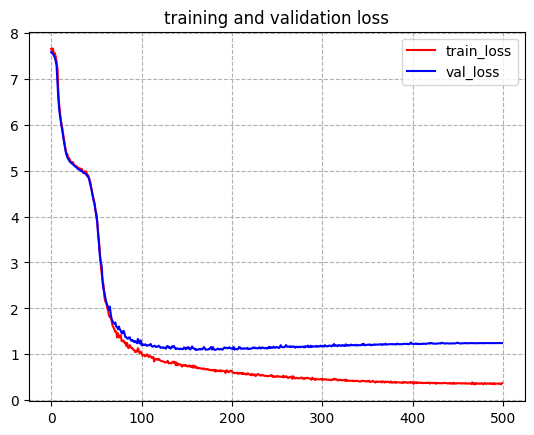

In [1]:
from log_record import record_log, read_log
from utils import visual_train

history = read_log("/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230810/unetlogs/log.txt")
visual_train(history)